In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, "../")

## Import

In [3]:
from collections import OrderedDict
import numpy
import pandas

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

from rep.metaml import FoldingClassifier

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
from utils import get_N_B_events, predict_by_estimator, bootstrap_calibrate_prob
from utils import get_events_number, get_events_statistics, result_table, compute_mistag

## Reading initial data

In [5]:
import root_numpy
def read_samples(filename, filename_vtx):
    datasets = dict()
    for name, selection, f in zip(['K', 'e', 'mu', 'vtx'], 
                                  ['K_cut == 1', 'e_cut == 1', 'mu_cut == 1', '(v_cut == 1) & (vcharge > 0.2)'],
                                  [filename] * 3 + [filename_vtx]):
        data = pandas.DataFrame(root_numpy.root2array(f, selection=selection))                       
        if name == 'vtx':
            data['label'] = (data.signB.values * data.signVtx.values < 0) * 1
        else:
            data['label'] = (data.signB.values * data.signTrack.values < 0) * 1
        data['event_id'] = data.run.apply(str) + '_' + data.event.apply(int).apply(str)
        data['tagAnswer'] = data.signB * (2 * data.label - 1)
        data['N_sig_sw'] = 1.
        datasets[name] = data
    
    return datasets

In [6]:
def compute_efficiencies(datasets, N_B_events):
    result = dict()
    for key, data in datasets.items():
        N_B_passed = get_events_number(data)
        result[key] = (1. * N_B_passed / N_B_events, sqrt(N_B_passed) / N_B_events)
    return result

In [ ]:
datasets = read_samples('../datasets/MC/csv/WG/Bu_JPsiK/2012/Tracks.root',
                        '../datasets/MC/csv/WG/Bu_JPsiK/2012/Vertices.root')

In [ ]:
datasets_kstar = read_samples('../datasets/MC/csv/WG/Bd_JPsiKstar/2012/Tracks.root',
                              '../datasets/MC/csv/WG/Bd_JPsiKstar/2012/Vertices.root')
datasets_ks = read_samples('../datasets/MC/csv/WG/Bd_JPsiKs/2012/Tracks.root',
                           '../datasets/MC/csv/WG/Bd_JPsiKs/2012/Vertices.root')

## Calculate $\epsilon_{tag}$ for each datasets

In [ ]:
from utils import compute_N_B_events_MC
N_B_events = compute_N_B_events_MC('../datasets/MC/csv/WG/Bu_JPsiK/2012/Tracks.root',
                                   '../datasets/MC/csv/WG/Bu_JPsiK/2012/Vertices.root')
N_B_events_kstar = compute_N_B_events_MC('../datasets/MC/csv/WG/Bd_JPsiKstar/2012/Tracks.root',
                                         '../datasets/MC/csv/WG/Bd_JPsiKstar/2012/Vertices.root')
N_B_events_ks = compute_N_B_events_MC('../datasets/MC/csv/WG/Bd_JPsiKs/2012/Tracks.root',
                                      '../datasets/MC/csv/WG/Bd_JPsiKs/2012/Vertices.root')

In [ ]:
N_B_events, N_B_events_kstar, N_B_events_ks

In [ ]:
eff = compute_efficiencies(datasets, N_B_events)
eff_kstar = compute_efficiencies(datasets_kstar, N_B_events_kstar)
eff_ks = compute_efficiencies(datasets_ks, N_B_events_ks)

In [ ]:
print 'K+-'
print pandas.DataFrame(eff)
print 'K*'
print pandas.DataFrame(eff_kstar)
print 'Ks'
print pandas.DataFrame(eff_ks)

## Features used in training

In [ ]:
features_vtx = ['mult', 'nnkrec', 'log_ptB: log(ptB)', 'vflag', 'log_ipsmean: log(ipsmean)', 
                'log_ptmean: log(ptmean)', 'vcharge', 
                'log_svm: log(svm)', 'log_svp: log(svp)', 'BDphiDir', 'log_svtau: log(svtau)', 'docamax']

features_ele = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'log_eOverP: log(EOverP)', 
                'ghostProb', 'log_IPPU: log(IPPU)']
features_muon = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'PIDNNm', 'ghostProb', 'log_IPPU: log(IPPU)']
features_kaon = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                 'nnkrec','log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 
                'PIDNNk', 'PIDNNpi', 'PIDNNp', 'ghostProb', 'log_IPPU: log(IPPU)']
                                    
features = {'e': features_ele, 'mu': features_muon,
            'K': features_kaon, 'vtx': features_vtx}

# features_tr = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
#                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'ghostProb', 'log_IPPU: log(IPPU)', 
#                'log_EOverP: log(EOverP)', 
#                'PIDNNpi', 'PIDNNp', 'PIDNNk', 'PIDNNm', 'PIDNNe', 'nnkrec', 'log_partTheta: log(partTheta)',
#                'log_partPhi: log(partPhi)', 'veloch']

In [ ]:
estimators = OrderedDict()

### XGBoost

In [15]:
from rep.estimators import XGBoostClassifier
from rep.metaml import FoldingClassifier

xgb_base_ele = XGBoostClassifier(colsample=0.8, eta=0.01, nthreads=4, 
                                 n_estimators=200, subsample=0.5, max_depth=5) 

xgb_base_other = XGBoostClassifier(colsample=0.8, eta=0.01, nthreads=4, 
                                   n_estimators=500, subsample=0.5, max_depth=5) 

for key, data in datasets.items():
    if 'e' in key:
        xgb_base = xgb_base_ele
    else:
        xgb_base = xgb_base_other
        
    estimators[key + '_xgboost'] = FoldingClassifier(xgb_base, n_folds=2, random_state=523,
                                                     features=features[key])
    estimators[key + '_xgboost'].fit(data, data['label'], data['N_sig_sw'])

### TMVA

In [16]:
from rep.estimators import TMVAClassifier
from rep.metaml import FoldingClassifier

tmva_base_muon = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N', sigmoid_function='identity',
                                NeuronType='tanh', NCycles=280, HiddenLayers='N+5', TrainingMethod='BFGS', TestRate=5,
                                UseRegulator=True, EstimatorType='CE')

tmva_base_ele = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N', sigmoid_function='identity',
                               NeuronType='sigmoid', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                               UseRegulator=True)

tmva_base_kaon_vtx = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N', 
                                    sigmoid_function='identity',
                                    NeuronType='tanh', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                                    UseRegulator=True, EstimatorType='CE')


for key, data in datasets.items():
    if 'e' in key:
        tmva_base = tmva_base_ele
    elif 'mu' in key:
        tmva_base = tmva_base_muon
    else:
        tmva_base = tmva_base_kaon_vtx
    estimators[key + '_tmva'] = FoldingClassifier(tmva_base, n_folds=2, random_state=523, features=features[key])
    estimators[key + '_tmva'].fit(data, data['label'], data['N_sig_sw'])

#error "You need a ISO C conforming compiler to use the glibc headers"
*** Interpreter error recovered ***
--- Factory                  : You are running ROOT Version: 5.34/32, Jun 23, 2015
--- Factory                  : 
--- Factory                  : _/_/_/_/_/ _|      _|  _|      _|    _|_|   
--- Factory                  :    _/      _|_|  _|_|  _|      _|  _|    _| 
--- Factory                  :   _/       _|  _|  _|  _|      _|  _|_|_|_| 
--- Factory                  :  _/        _|      _|    _|  _|    _|    _| 
--- Factory                  : _/         _|      _|      _|      _|    _| 
--- Factory                  : 
--- Factory                  : ___________TMVA Version 4.2.0, Sep 19, 2013
--- Factory                  : 
--- DataSetInfo              : Added class "Signal"	 with internal class number 0
--- DataSetInfo              : Added class "Background"	 with internal class number 1
--- Factory                  : Add Tree TrainAssignTree_Signal of type Signal with 25886 ev

In [ ]:
# import cPickle
# with open('../models/old-tagging-MC.pkl', 'r') as f:
#     estimators = cPickle.load(f)

In [18]:
import cPickle
with open('../models/old-tagging-MC.pkl', 'w') as f:
    cPickle.dump(estimators, f)

In [16]:
estimators.keys()

['mu_xgboost',
 'vtx_xgboost',
 'K_xgboost',
 'e_xgboost',
 'mu_tmva',
 'vtx_tmva',
 'K_tmva',
 'e_tmva']

In [17]:
for key in datasets.keys():
    for suffix in ['_xgboost', '_tmva']:
        name = key + suffix
        for data, label in zip([datasets[key], datasets_kstar[key], datasets_ks[key]],
                               ['K+-', 'K*', 'Ks']):
            probs = estimators[name].predict_proba(data)[:, 1]        
            print name, label, 'AUC:', roc_auc_score(data['label'].values, 
                                                     probs, sample_weight=data['N_sig_sw'].values)

KFold prediction using folds column
mu_xgboost K+- AUC: 0.60261930448
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_xgboost K* AUC: 0.611230272746
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_xgboost Ks AUC: 0.607932772058
KFold prediction using folds column
mu_tmva K+- AUC: 0.592940364243
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_tmva K* AUC: 0.598676563222
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_tmva Ks AUC: 0.606136962522
KFold prediction using folds column
vtx_xgboost K+- AUC: 0.588917449491
KFold prediction using random classifier (length of data passed not equal to length of train)
vtx_xgboost K* AUC: 0.587977742307
KFold prediction using random classifier (length of data passed not equal to length of train)
vtx_xgboost Ks AUC: 0.578570099855
KFold prediction using fol

--------

## Calculate quality for each tagger (ele, muon, kaon, vtx)

using isotonic final calibration with bootstrap

In [18]:
from utils import predict_by_estimator, calibrate_probs, estimate_taggers_old_scheme

def combine(estimators, datasets, keys, N_B_events, logistic=False,
            return_calibrations=False, logistic_combined=True, model_name=None, with_roc=False):
    """
    :param suffix: suffix used for taggers
    :param model_name: name for model after combining classifiers
    """
    data_with_predictions = {}
    calibrators_tracks = dict()
    
    # computing calibrated predictions of each tagger
    for key in keys:
        data, probs = predict_by_estimator(estimators[key], [datasets[key]])
        probs_calibrated, calibrators_tracks[key] = \
            calibrate_probs(data.label.values, data.N_sig_sw.values, probs, logistic=logistic)
            
        ids = numpy.array(data['event_id'])
        data_with_predictions[key] = pandas.DataFrame({'prob_{}'.format(key): probs_calibrated, 
                                                       'tag_{}'.format(key): data.tagAnswer.values,
                                                       'weight': data.N_sig_sw.values,
                                                       'signB': data.signB.values}, index=ids)
        
    calibrator_B, table, roc = estimate_taggers_old_scheme(data_with_predictions, keys, N_B_events, 
                                                           model_name=','.join(keys) if model_name is None else model_name, 
                                                           logistic_combined=logistic_combined)
    if return_calibrations and with_roc:
        return table, calibrators_tracks, calibrator_B, roc
    elif return_calibrations and not with_roc:
        return table, calibrators_tracks, calibrator_B
    elif with_roc:
        return table, roc
    else:
        return table

### TMVA

In [19]:
test_estimators_tmva = dict((key, estimators[key + '_tmva']) for key in ['K', 'mu', 'e', 'vtx'])

KFold prediction using folds column
AUC for tagged: 0.726351149079 AUC with untag: 0.518457825518


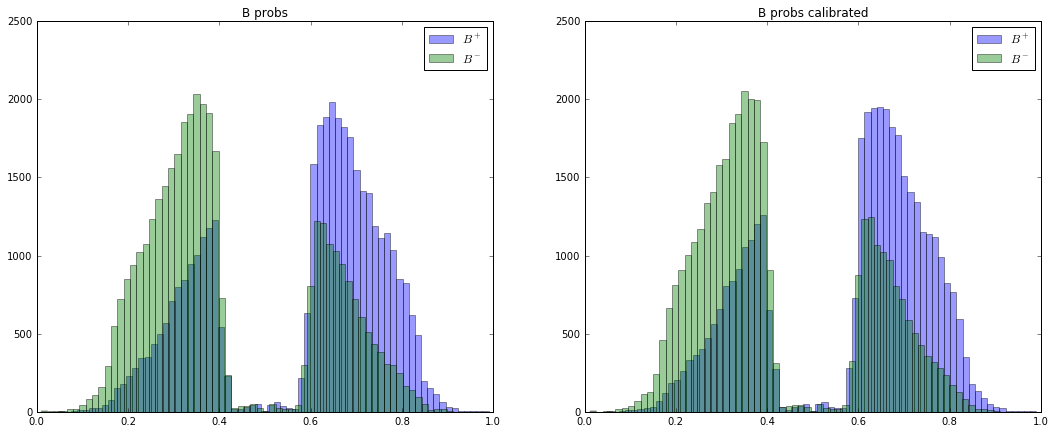

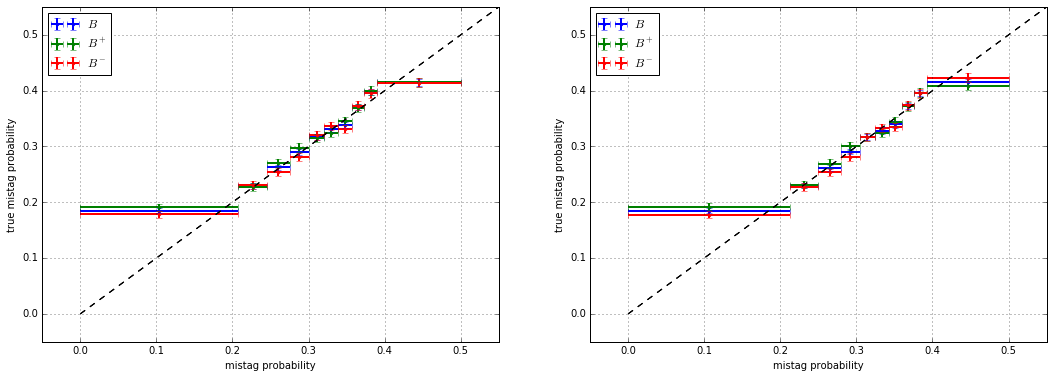

Efficiency, not calibrated 0.832908352542
Average AUC 0.726311426806 6.390834128e-05
KFold prediction using folds column
AUC for tagged: 0.671594489405 AUC with untag: 0.532486901488


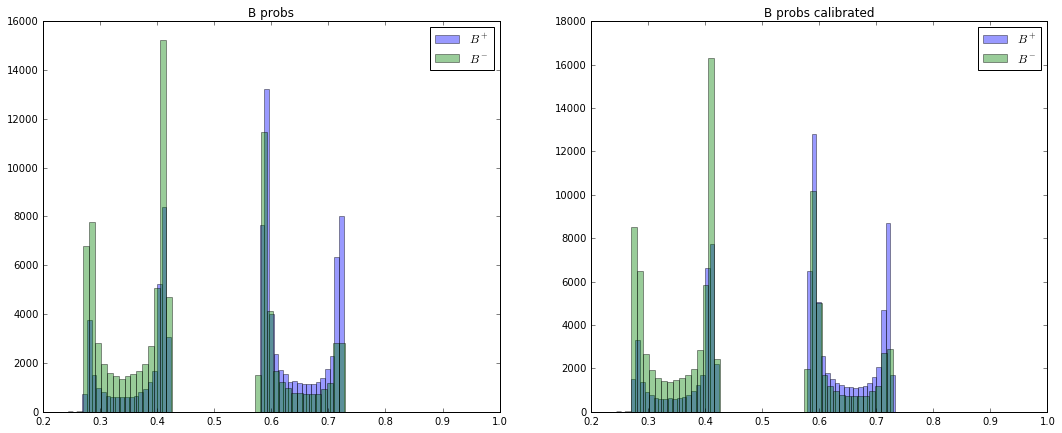

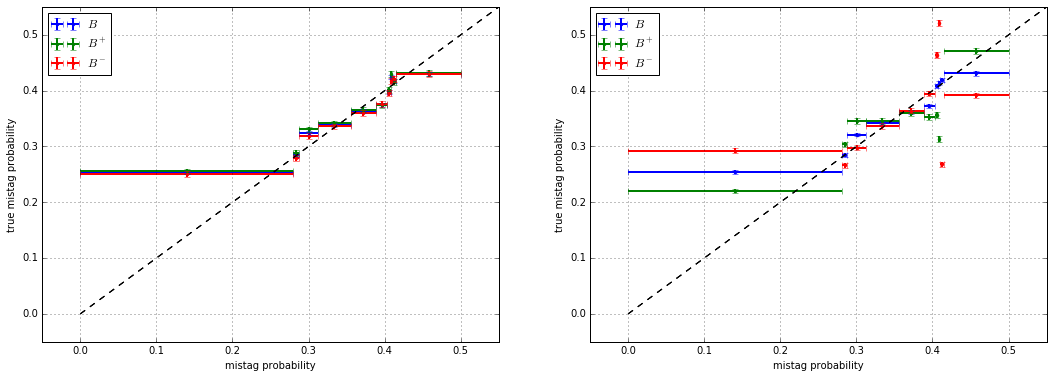

Efficiency, not calibrated 1.09560516459
Average AUC 0.67142007776 9.7100842861e-05
KFold prediction using folds column
AUC for tagged: 0.67860053712 AUC with untag: 0.551345124444


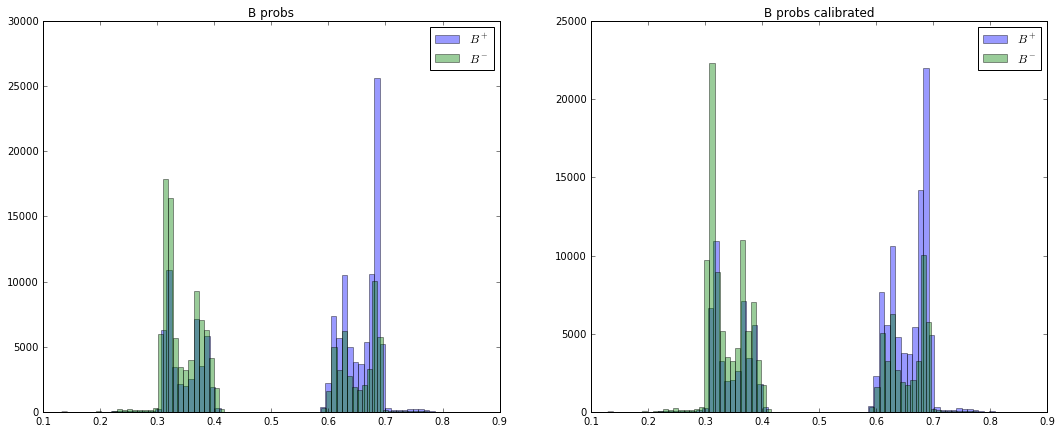

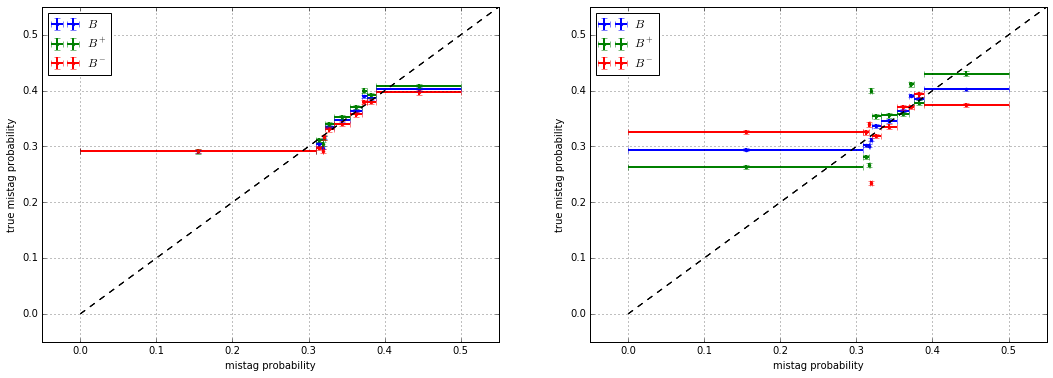

Efficiency, not calibrated 1.80481556496
Average AUC 0.678432857576 0.000109161995698
KFold prediction using folds column
AUC for tagged: 0.698873776807 AUC with untag: 0.506609931918


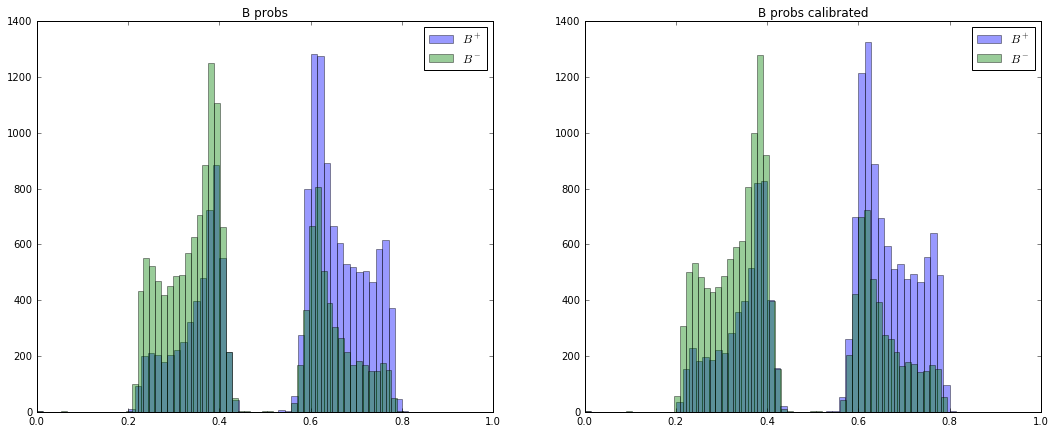

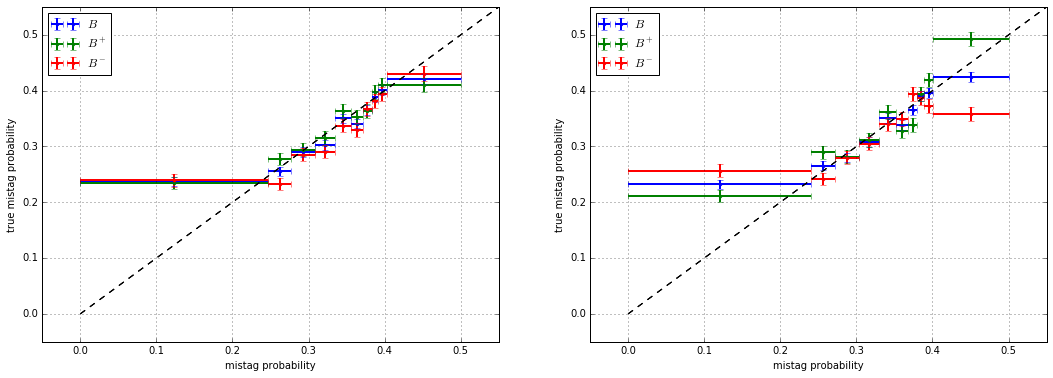

Efficiency, not calibrated 0.23642703254
Average AUC 0.698750282162 0.000150610894499


In [20]:
figsize(18, 7)

results_separate_tmva = []
for key in datasets.keys(): 
    x = combine(test_estimators_tmva, datasets, [key], N_B_events, logistic=True)
    results_separate_tmva.append(x)

In [21]:
pandas.concat(results_separate_tmva)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.157923,0.001368,0.798115,0.007499,51.845783,0
0,vtx,12.265035,0.028701,0.089629,0.000412,1.099299,0.005673,53.248690,0
0,K,17.759661,0.034537,0.103643,0.000381,1.840665,0.007651,55.134512,0
0,e,2.023049,0.011657,0.122208,0.001247,0.247233,0.002897,50.660993,0


### XGBoost

In [22]:
test_estimators = dict((key, estimators[key + '_xgboost']) for key in ['K', 'mu', 'e', 'vtx'])

KFold prediction using folds column
AUC for tagged: 0.730436671744 AUC with untag: 0.518396837178


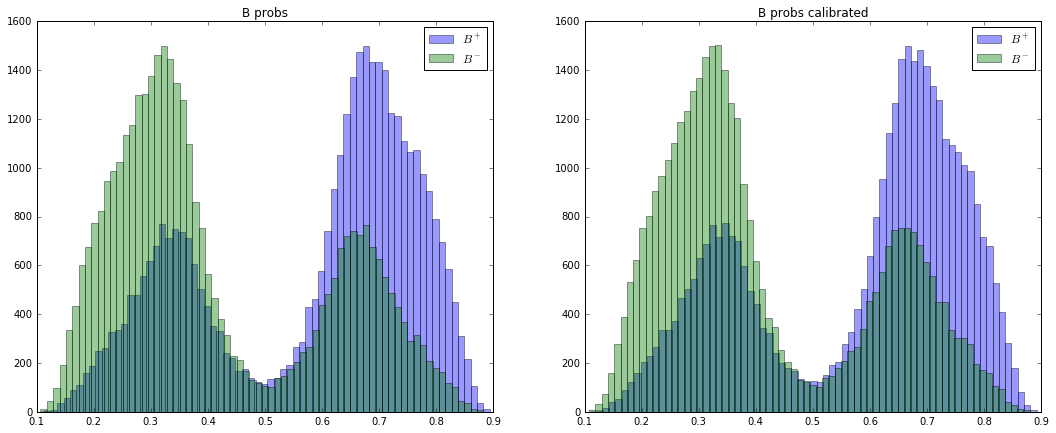

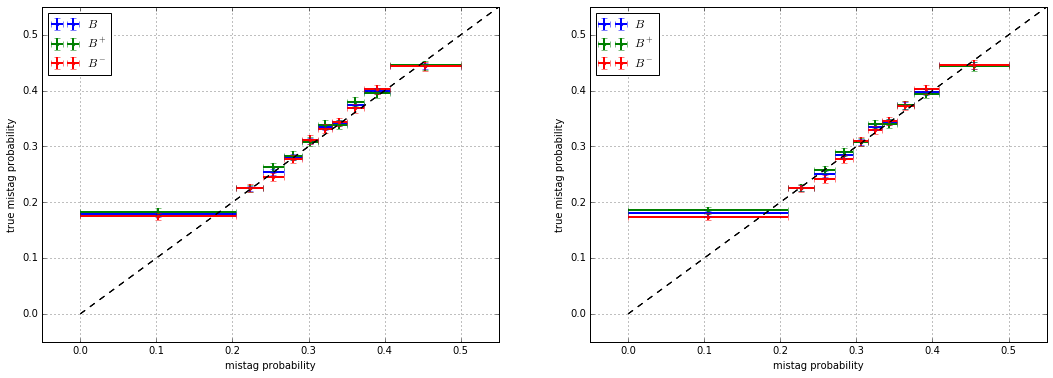

Efficiency, not calibrated 0.853230911628
Average AUC 0.730399628035 6.71465027744e-05
KFold prediction using folds column
AUC for tagged: 0.679790836959 AUC with untag: 0.532345022729


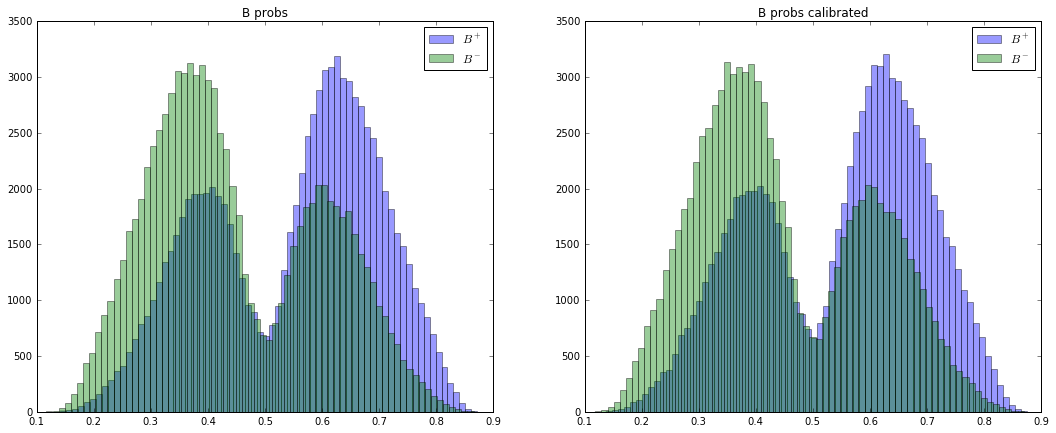

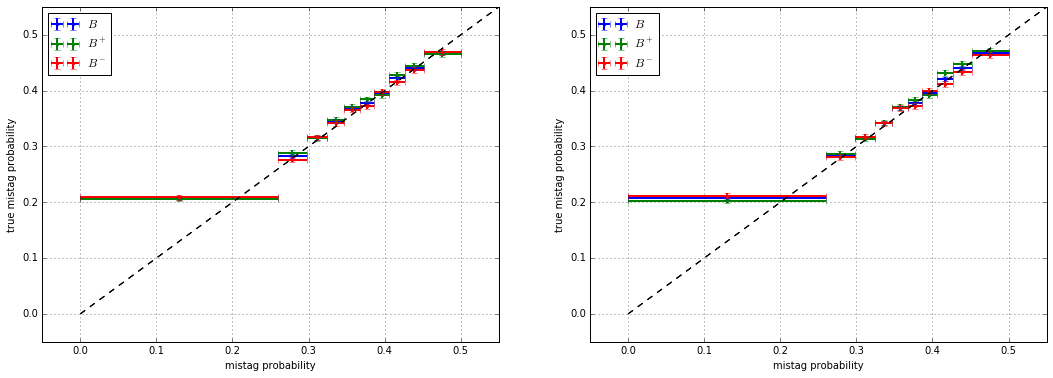

Efficiency, not calibrated 1.20698414177
Average AUC 0.679777935484 1.67809714232e-05
KFold prediction using folds column
AUC for tagged: 0.6906140029 AUC with untag: 0.551703026024


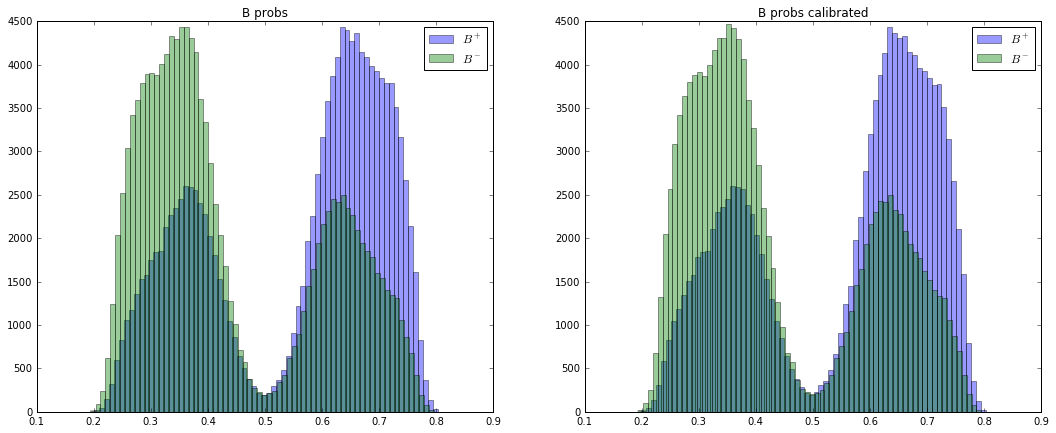

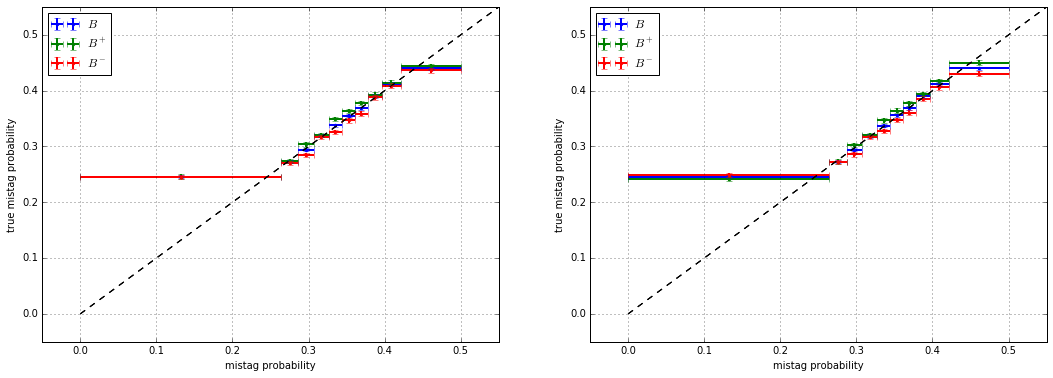

Efficiency, not calibrated 1.98966266328
Average AUC 0.690598436033 2.14522512864e-05
KFold prediction using folds column
AUC for tagged: 0.704694203363 AUC with untag: 0.50660836551


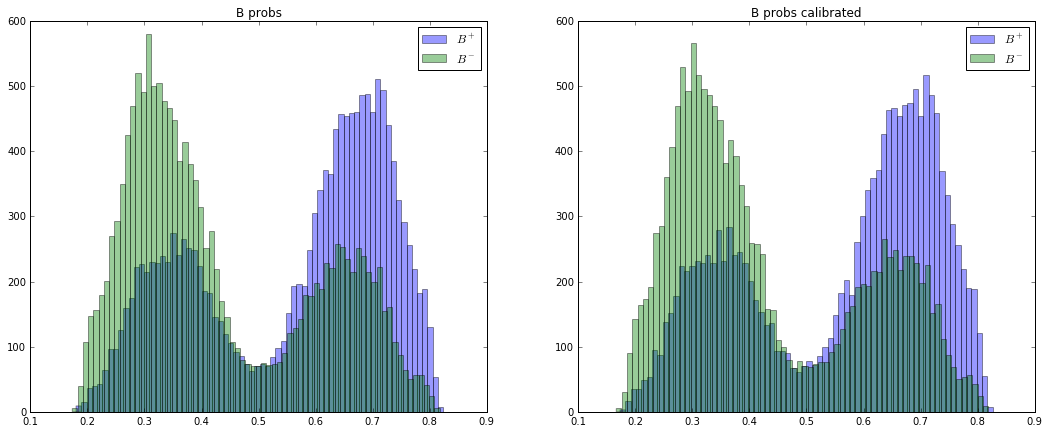

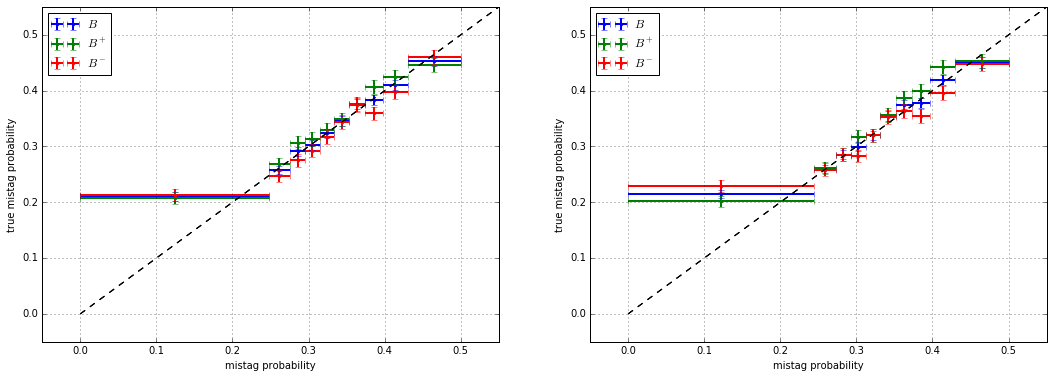

Efficiency, not calibrated 0.253846873039
Average AUC 0.704601276194 0.000114295549467


In [23]:
figsize(18, 7)

calibrators_B = dict()
calibrator_tracks = dict()

results_separate = []
for key in datasets.keys(): 
    x, calibrator_tracks[key], calibrators_B[key] = combine(test_estimators, datasets, [key], N_B_events,
                                                            logistic=True, return_calibrations=True)
    results_separate.append(x)

In [24]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.162459,0.001539,0.821040,0.008334,51.839684,0
0,vtx,12.265035,0.028701,0.098616,0.000459,1.209523,0.006297,53.234502,0
0,K,17.759661,0.034537,0.112161,0.000407,1.991945,0.008195,55.170303,0
0,e,2.023049,0.011657,0.128742,0.001369,0.260452,0.003149,50.660837,0


## test individuals taggers on K* and Ks

In [25]:
from utils import estimate_new_data_old_scheme

### K*

K
KFold prediction using random classifier (length of data passed not equal to length of train)


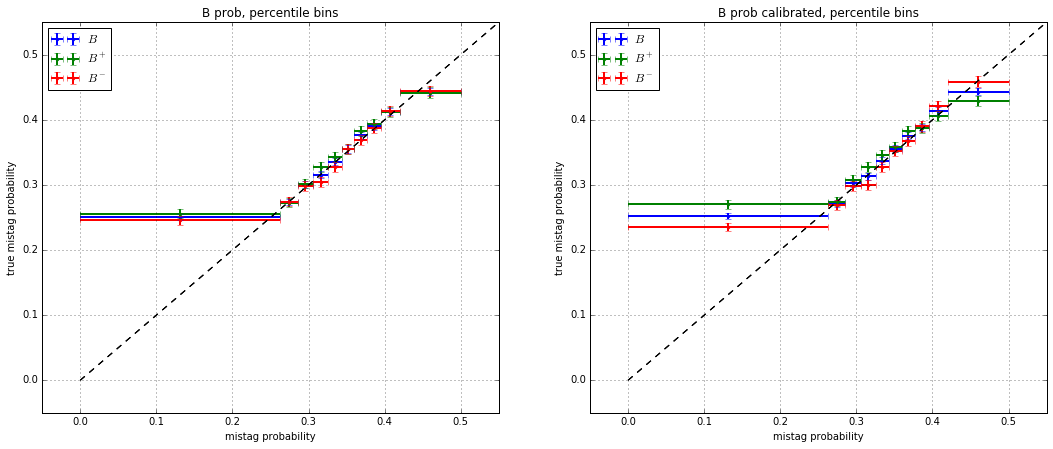

e
KFold prediction using random classifier (length of data passed not equal to length of train)


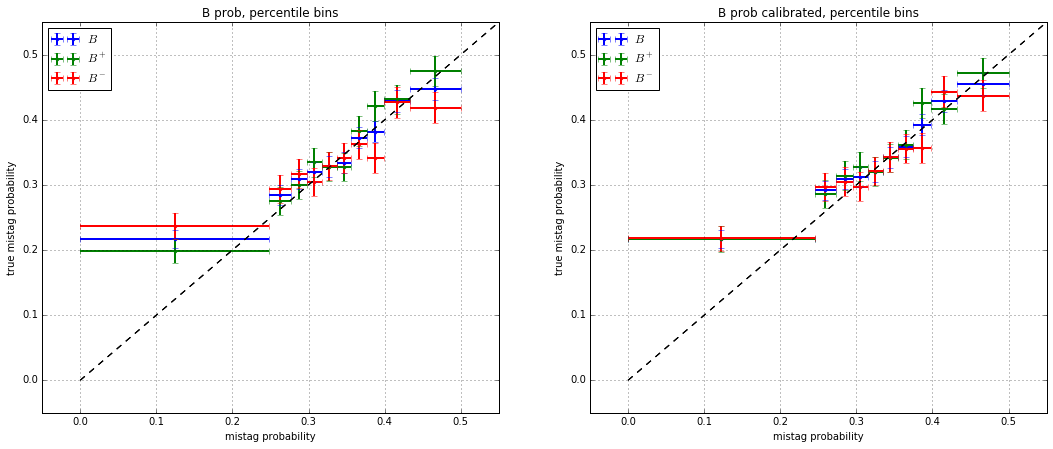

mu
KFold prediction using random classifier (length of data passed not equal to length of train)


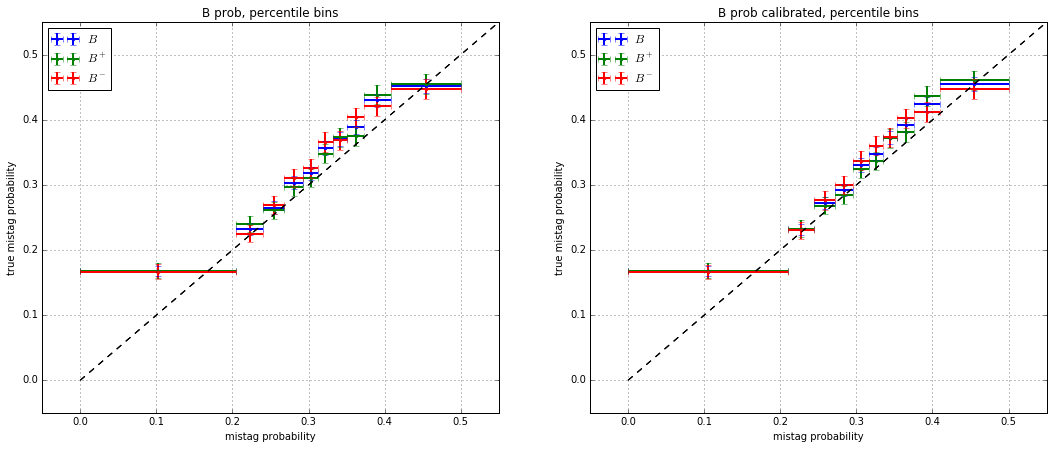

vtx
KFold prediction using random classifier (length of data passed not equal to length of train)


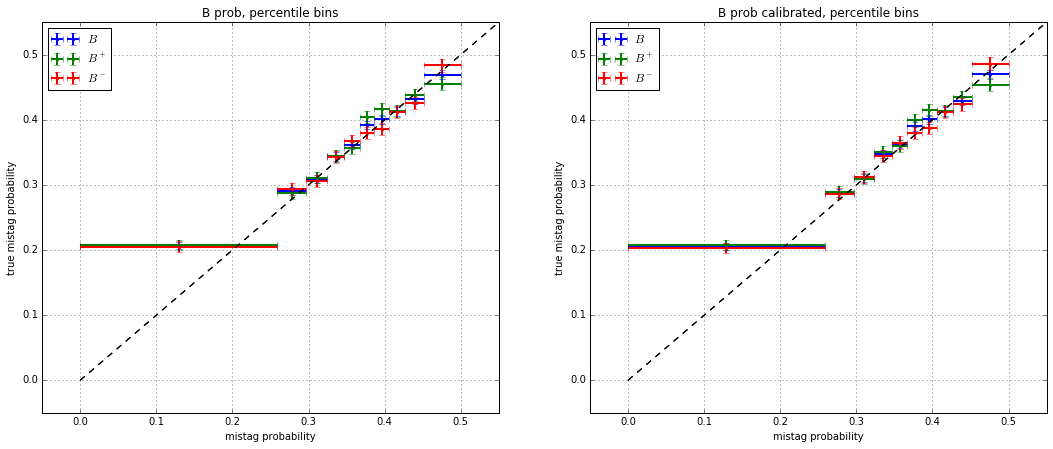

In [26]:
results_separate_kstar = []

for key in ['K', 'e', 'mu', 'vtx']:
    print key
    x = estimate_new_data_old_scheme(test_estimators, datasets_kstar, [key],
                                     calibrator_tracks[key], calibrators_B[key], 
                                     N_B_events_kstar, model_name='K* ' + key)
    results_separate_kstar.append(x)

### Ks

K
KFold prediction using random classifier (length of data passed not equal to length of train)


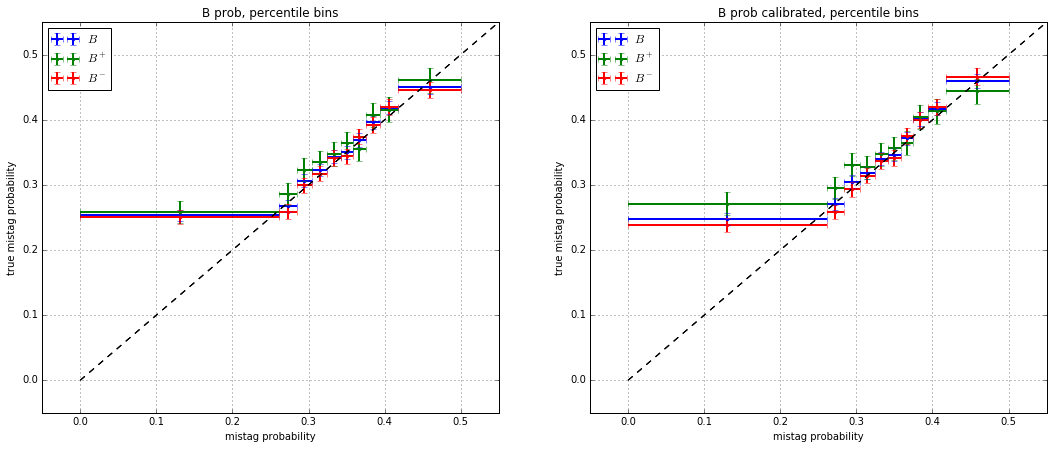

e
KFold prediction using random classifier (length of data passed not equal to length of train)


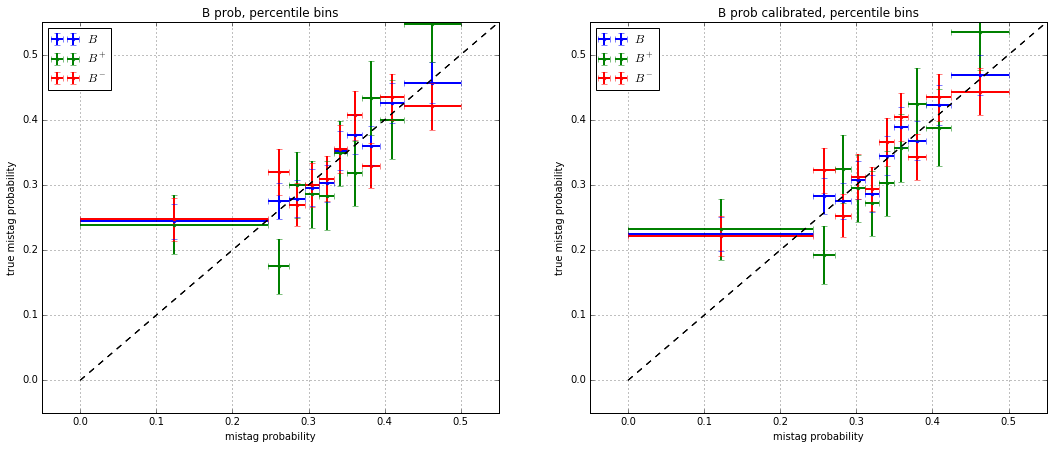

mu
KFold prediction using random classifier (length of data passed not equal to length of train)


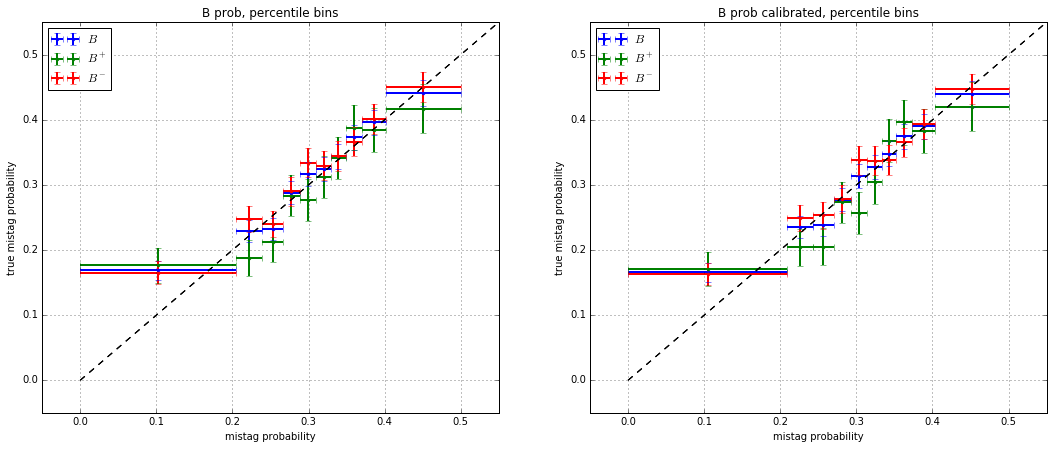

vtx
KFold prediction using random classifier (length of data passed not equal to length of train)


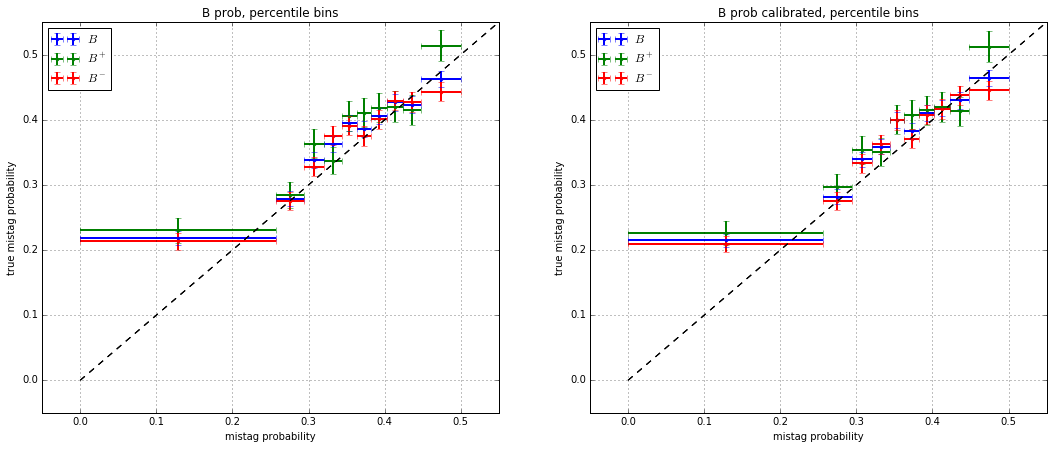

In [27]:
results_separate_ks = []

for key in ['K', 'e', 'mu', 'vtx']:
    print key
    x = estimate_new_data_old_scheme(test_estimators, datasets_ks, [key],
                                     calibrator_tracks[key], calibrators_B[key], 
                                     N_B_events_ks, model_name='Ks ' + key)
    results_separate_ks.append(x)

In [28]:
pandas.concat(results_separate_kstar + results_separate_ks)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* K,17.949948,0.064485,0.113479,0,2.036935,0.007318,55.163053,0
0,K* e,2.065713,0.021876,0.126489,0,0.261291,0.002767,50.646037,0
0,K* mu,5.049726,0.034203,0.162053,0,0.818324,0.005543,51.701056,0
0,K* vtx,12.413041,0.053625,0.099109,0,1.230244,0.005315,53.279870,0
0,Ks K,17.390640,0.115273,0.115415,0,2.007135,0.013304,54.866625,0
0,Ks e,1.969819,0.038796,0.131601,0,0.259231,0.005106,50.636061,0
0,Ks mu,4.935244,0.061408,0.165429,0,0.816434,0.010159,51.820314,0
0,Ks vtx,11.982426,0.095685,0.102648,0,1.229967,0.009822,52.950957,0


# Combination of all taggers

### TMVA

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
AUC for tagged: 0.689765360619 AUC with untag: 0.577919971799


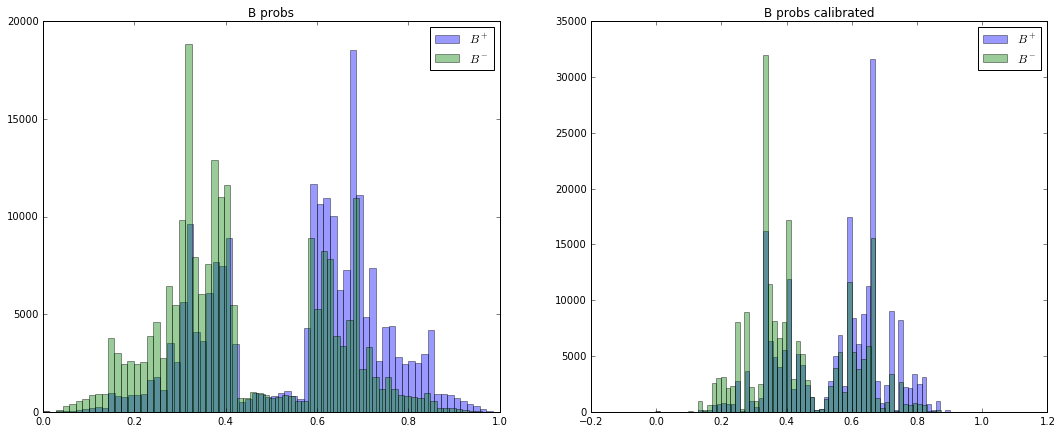

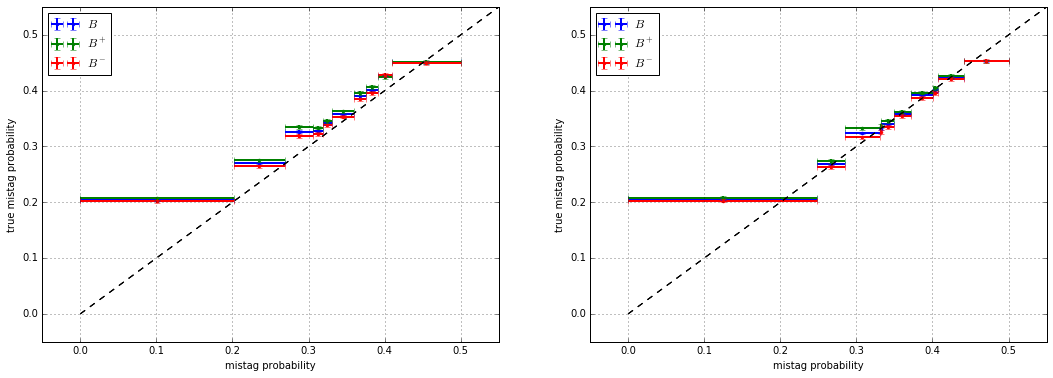

Efficiency, not calibrated 4.33568047738
Average AUC 0.68969503732 5.86993113305e-05


In [29]:
figsize(18, 7)

x, calibrator_tracks_comb_tmva, calibrator_B_comb_tmva, roc_curve_old_tmva = \
    combine(test_estimators_tmva, datasets,
             ['K', 'e', 'mu', 'vtx'], 
             N_B_events, logistic=True,
             return_calibrations=True, logistic_combined=False,
             model_name='tmva combination', with_roc=True)
results_separate_tmva.append(x)

### XGBoost

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
AUC for tagged: 0.69647990046 AUC with untag: 0.578715078214


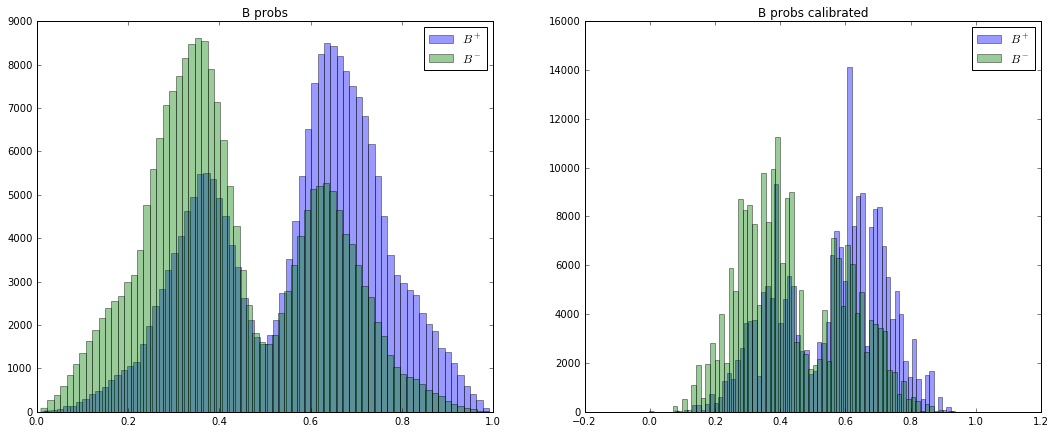

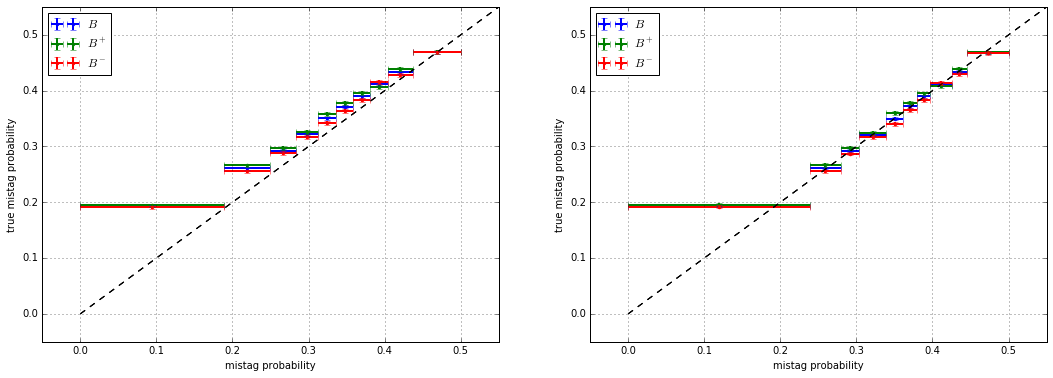

Efficiency, not calibrated 4.63029956468
Average AUC 0.696311810402 4.00344798783e-05


In [30]:
figsize(18, 7)

x, calibrator_tracks_comb, calibrator_B_comb, roc_curve_old = combine(test_estimators, datasets, 
                                                                      ['K', 'e', 'mu', 'vtx'], N_B_events,
                                                                      logistic=True, return_calibrations=True,
                                                                      logistic_combined=False,
                                                                      model_name='xgboost combination', with_roc=True)
results_separate.append(x)

In [31]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.162459,0.001539,0.821040,0.008334,51.839684,0
0,vtx,12.265035,0.028701,0.098616,0.000459,1.209523,0.006297,53.234502,0
0,K,17.759661,0.034537,0.112161,0.000407,1.991945,0.008195,55.170303,0
0,e,2.023049,0.011657,0.128742,0.001369,0.260452,0.003149,50.660837,0
0,xgboost combination,29.043496,0.044167,0.117465,0.000031,3.411594,0.005267,57.871508,0


## Test combination of taggers on K* and Ks

### K*

#### xgboost

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


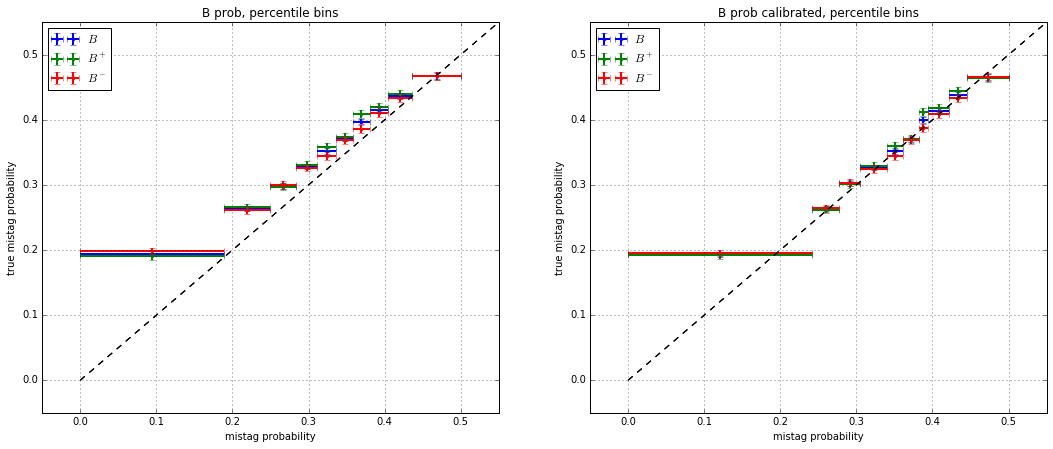

In [32]:
x = estimate_new_data_old_scheme(test_estimators, datasets_kstar, ['K', 'e', 'mu', 'vtx'],
                                 calibrator_tracks_comb, calibrator_B_comb, N_B_events_kstar, 
                                 model_name='K* combination')
results_separate_kstar.append(x)

#### tmva

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


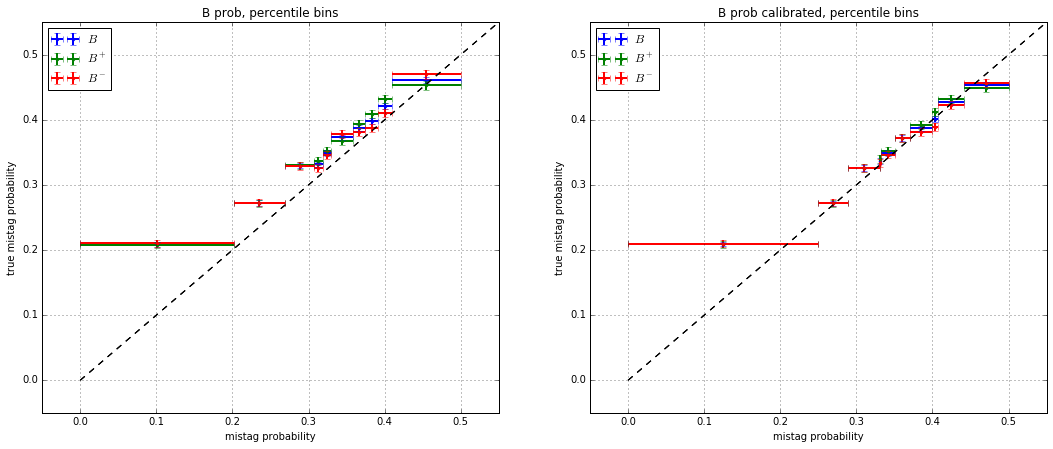

In [33]:
x = estimate_new_data_old_scheme(test_estimators_tmva, datasets_kstar, ['K', 'e', 'mu', 'vtx'],
                                 calibrator_tracks_comb_tmva, calibrator_B_comb_tmva, N_B_events_kstar, 
                                 model_name='K* combination')

In [34]:
x

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* combination,29.30824,0.082399,0.111179,0,3.258474,0.009161,57.672729,0


### Ks

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


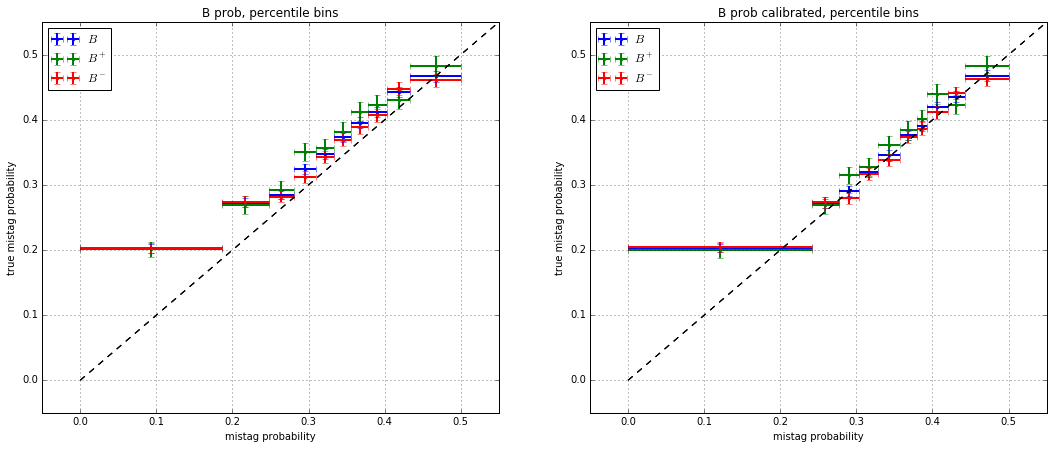

In [35]:
x = estimate_new_data_old_scheme(test_estimators, datasets_ks, ['K', 'e', 'mu', 'vtx'],
                                 calibrator_tracks_comb, calibrator_B_comb, N_B_events_ks, 
                                 model_name='Ks combination')
results_separate_ks.append(x)

# Final results

### TMVA

In [36]:
pandas.concat(results_separate_tmva)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.157923,0.001368,0.798115,0.007499,51.845783,0
0,vtx,12.265035,0.028701,0.089629,0.000412,1.099299,0.005673,53.248690,0
0,K,17.759661,0.034537,0.103643,0.000381,1.840665,0.007651,55.134512,0
0,e,2.023049,0.011657,0.122208,0.001247,0.247233,0.002897,50.660993,0
0,tmva combination,29.043496,0.044167,0.110931,0.000021,3.221838,0.004937,57.791997,0


### XGBoost

In [37]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.162459,0.001539,0.821040,0.008334,51.839684,0
0,vtx,12.265035,0.028701,0.098616,0.000459,1.209523,0.006297,53.234502,0
0,K,17.759661,0.034537,0.112161,0.000407,1.991945,0.008195,55.170303,0
0,e,2.023049,0.011657,0.128742,0.001369,0.260452,0.003149,50.660837,0
0,xgboost combination,29.043496,0.044167,0.117465,0.000031,3.411594,0.005267,57.871508,0


In [38]:
pandas.concat(results_separate_kstar)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* K,17.949948,0.064485,0.113479,0,2.036935,0.007318,55.163053,0
0,K* e,2.065713,0.021876,0.126489,0,0.261291,0.002767,50.646037,0
0,K* mu,5.049726,0.034203,0.162053,0,0.818324,0.005543,51.701056,0
0,K* vtx,12.413041,0.053625,0.099109,0,1.230244,0.005315,53.279870,0
0,K* combination,29.308240,0.082399,0.117617,0,3.447158,0.009692,57.767091,0


In [39]:
pandas.concat(results_separate_ks)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,Ks K,17.390640,0.115273,0.115415,0,2.007135,0.013304,54.866625,0
0,Ks e,1.969819,0.038796,0.131601,0,0.259231,0.005106,50.636061,0
0,Ks mu,4.935244,0.061408,0.165429,0,0.816434,0.010159,51.820314,0
0,Ks vtx,11.982426,0.095685,0.102648,0,1.229967,0.009822,52.950957,0
0,Ks combination,28.387393,0.147277,0.119903,0,3.403736,0.017659,57.402882,0


In [40]:
pandas.concat(results_separate_tmva + results_separate + results_separate_kstar + results_separate_ks).to_csv(
    '../img/old-tagging-MC.csv', header=True, index=False)

In [41]:
import cPickle
with open('../models/old-rocs-MC', 'w') as f:
    cPickle.dump(roc_curve_old, f)

# Prepare for EPM

In [42]:
from utils import prepare_for_epm_old_scheme

In [43]:
kstar_flavour = pandas.DataFrame(root_numpy.root2array('../datasets/MC/csv/WG/Bd_JPsiKstar/2012/Tracks.root',
                                                       branches=['run', 'event', 'K_MCID']))
kstar_flavour['event_id'] = kstar_flavour.run.apply(str) + '_' + kstar_flavour.event.apply(int).apply(str)
_, ids = numpy.unique(kstar_flavour.event_id, return_index=True)
kstar_flavour = kstar_flavour.loc[ids, :]

In [44]:
kstar_flavour.index = kstar_flavour.event_id
vals = kstar_flavour.loc[datasets_kstar['vtx'].event_id.values, 'K_MCID']
datasets_kstar['vtx']['K_MCID'] = vals.values

In [45]:
prepared_kstar = prepare_for_epm_old_scheme(test_estimators, datasets_kstar, ['K', 'e', 'mu', 'vtx'],
                                            calibrator_tracks_comb, calibrator_B_comb, N_B_events_kstar)
root_numpy.array2root(prepared_kstar.to_records(index=False), "../EPM/kstar_MC_old.root", 
                      mode='recreate')

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
eff tag:  0.293082399164
D2: 0.117617354136
eff: 0.0344715763334


In [46]:
from utils import compute_mistag

In [47]:
# remove last line which correspond to all not passed events
mask = prepared_kstar[:-1]

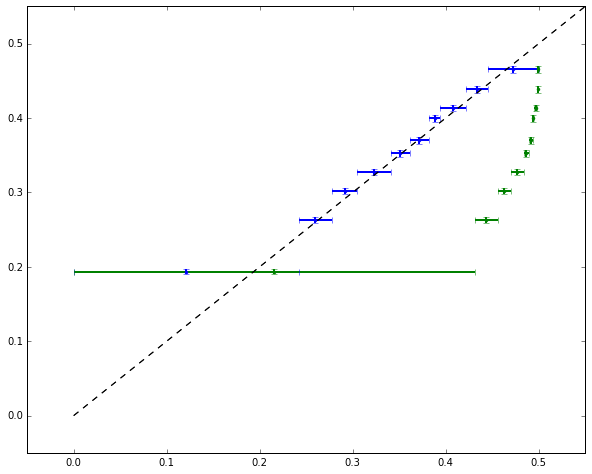

In [48]:
figure(figsize=(10, 8))
compute_mistag(mask['probs'].values, mask['signB'].values, mask['weight'].values, mask['signB'].values > -100,
               uniform=False, bins=numpy.linspace(10, 90, 9))
p = (2*(mask['probs'].values - 0.5))**3 / 2 + 0.5
compute_mistag(p, mask['signB'].values, mask['weight'].values, mask['signB'].values > -100,
               uniform=False, bins=numpy.linspace(10, 90, 9))

In [49]:
prepared_kstar_bad = prepared_kstar.copy()
prepared_kstar_bad['probs'] = list(p) + [0.5]
prepared_kstar_bad['mistag'] = list(numpy.minimum(p, 1-p)) + [0.5]
prepared_kstar_bad['tag'] = list(numpy.where(p > 0.5, 1, -1)) + [0]
root_numpy.array2root(prepared_kstar_bad.to_records(index=False), "../EPM/kstar_MC_old_bad_calibration.root", 
                      mode='recreate')

### compute D2 in time bins

In [50]:
time_var = mask.decay_time
proba = mask.probs
weight = mask.weight

time_means = numpy.percentile(time_var, numpy.linspace(0, 100, 30))
time_bins = numpy.searchsorted(time_means, time_var)
d2_vs_time = numpy.bincount(time_bins, weights=(2*(proba - 0.5))**2) / numpy.bincount(time_bins, weights=weight)

In [51]:
errors = []
for i in range(30):
    probs_in_bin = proba[time_bins == i]
    errors.append(numpy.std((2*(probs_in_bin - 0.5))**2) / numpy.sqrt(len(probs_in_bin)))

In [52]:
time_means_bins = list(time_means[:-1] + (time_means[1:] - time_means[:-1]) / 2) + [max(time_var)]

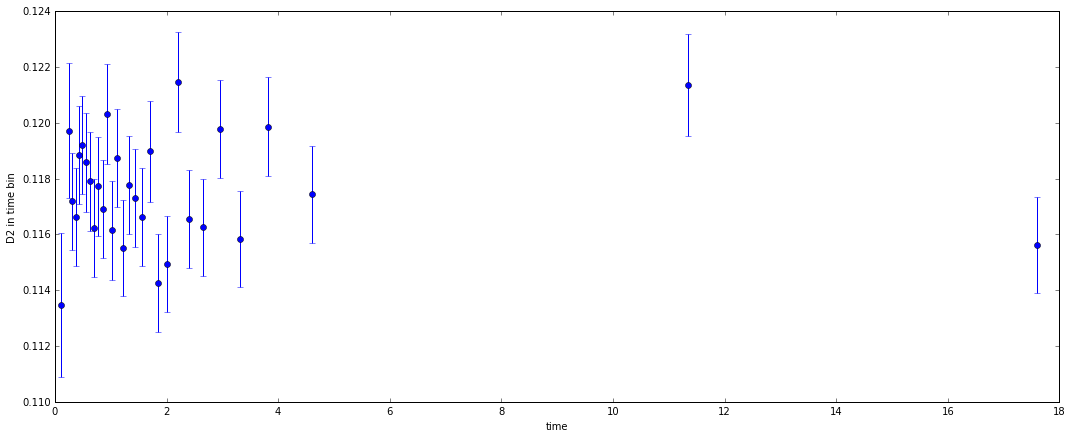

In [53]:
errorbar(time_means_bins, d2_vs_time, yerr=errors, fmt='o')
xlabel('time')
ylabel('D2 in time bin')

#### self calibrated

In [54]:
from sklearn.isotonic import IsotonicRegression
labels = (mask.signB > 0) * 1
iso_calibrator = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
iso_calibrator.fit(numpy.r_[proba, 1-proba], 
                   numpy.r_[labels, 1 - labels],
                   sample_weight=numpy.r_[weight, weight])
proba_self_calibrated = iso_calibrator.transform(proba)

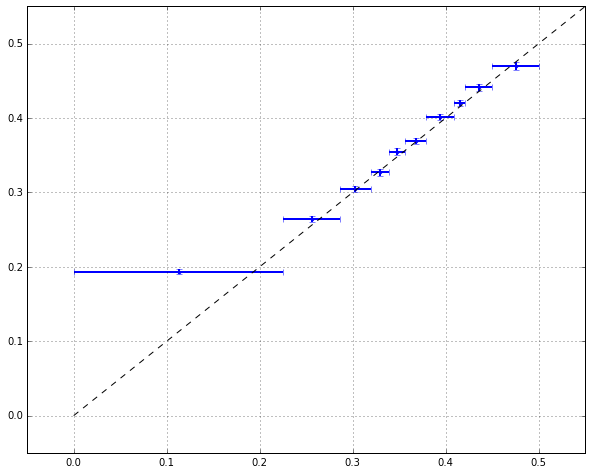

In [55]:
figure(figsize=(10, 8))
compute_mistag(proba_self_calibrated, mask['signB'].values, mask['weight'].values, mask['signB'].values > -100,
               uniform=False, bins=numpy.linspace(10, 90, 9))

In [56]:
sum(time_var > 0), len(time_var)

(124549, 126514)

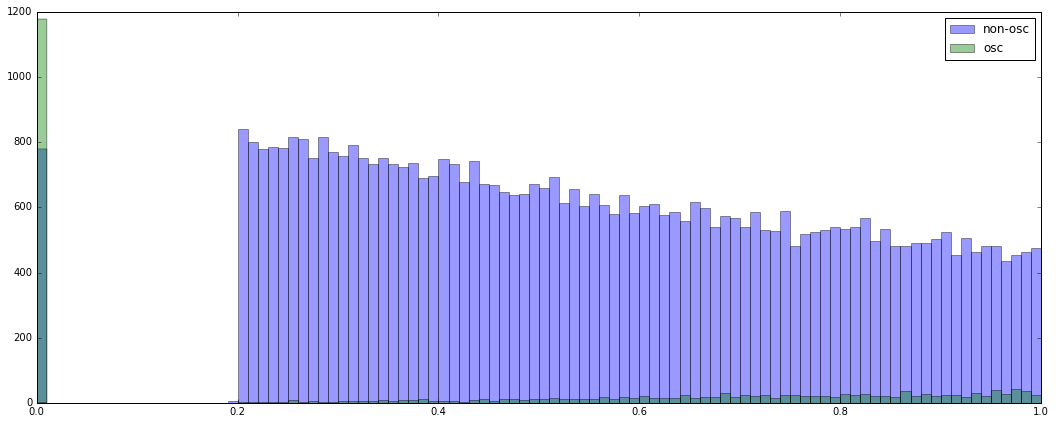

In [57]:
hist(time_var[mask.signB * mask.flavour == 1], bins=100, alpha=0.4, range=(0, 1), label='non-osc')
hist(time_var[mask.signB * mask.flavour == -1], bins=100, alpha=0.4, range=(0, 1), label='osc')
legend();

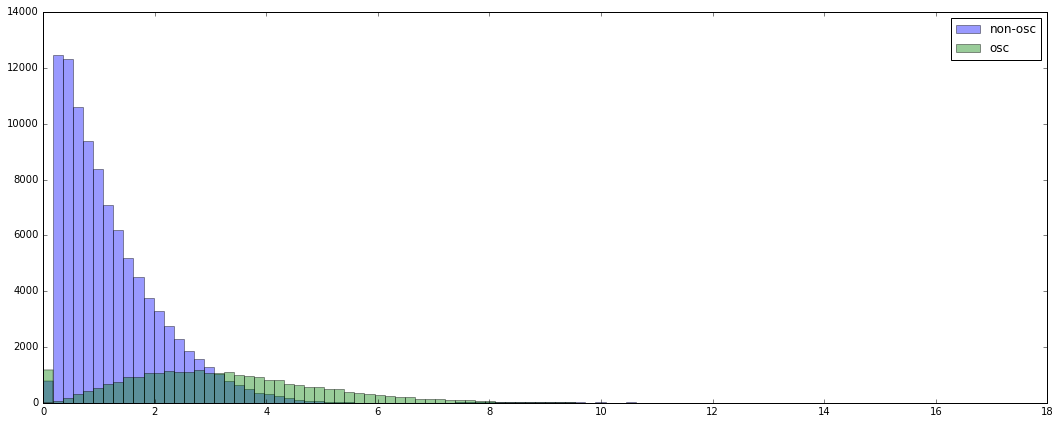

In [58]:
hist(time_var[mask.signB * mask.flavour == 1], bins=100, alpha=0.4, range=(0, 18), label='non-osc')
hist(time_var[mask.signB * mask.flavour == -1], bins=100, alpha=0.4, range=(0, 18), label='osc')
legend();

In [59]:
numpy.average((2 * (proba_self_calibrated - 0.5))**2), numpy.average((2 * (proba - 0.5))**2)

(0.11357603312646862, 0.11761735413565277)

In [60]:
prepared_kstar_self = prepared_kstar.copy()
prepared_kstar_self['probs'] = list(proba_self_calibrated) + [0.5]
prepared_kstar_self['mistag'] = list(numpy.minimum(proba_self_calibrated, 1-proba_self_calibrated)) + [0.5]
prepared_kstar_self['tag'] = list(numpy.where(proba_self_calibrated > 0.5, 1, -1)) + [0]
root_numpy.array2root(prepared_kstar_self.to_records(index=False), "../EPM/kstar_MC_old_self_calibration.root", 
                      mode='recreate')

### self calibration with holdout

In [61]:
from utils import CalibrationProcedure
self_calibrator = CalibrationProcedure(symmetrize=True, random_state=54)
self_calibrator.fit(proba, mask.signB, sample_weight=weight)
proba_self_calibrated_holdout = self_calibrator.predict_proba(proba)

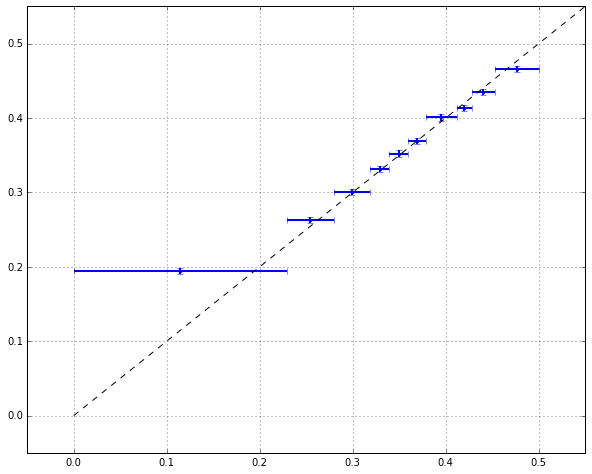

In [62]:
figure(figsize=(10, 8))
compute_mistag(proba_self_calibrated_holdout, mask['signB'].values, mask['weight'].values, mask['signB'].values > -100,
               uniform=False, bins=numpy.linspace(10, 90, 9))

In [63]:
prepared_kstar_self = prepared_kstar.copy()
prepared_kstar_self['probs'] = list(proba_self_calibrated_holdout) + [0.5]
prepared_kstar_self['mistag'] = list(numpy.minimum(proba_self_calibrated_holdout, 1-proba_self_calibrated_holdout)) + [0.5]
prepared_kstar_self['tag'] = list(numpy.where(proba_self_calibrated_holdout > 0.5, 1, -1)) + [0]
root_numpy.array2root(prepared_kstar_self.to_records(index=False), "../EPM/kstar_MC_old_self_calibration_holdout.root", 
                      mode='recreate')

-------------------

### predict by tmva

In [64]:
prepared_kstar = prepare_for_epm_old_scheme(test_estimators_tmva, datasets_kstar, ['K', 'e', 'mu', 'vtx'],
                                            calibrator_tracks_comb_tmva, calibrator_B_comb_tmva, N_B_events_kstar)
root_numpy.array2root(prepared_kstar.to_records(index=False), "../EPM/kstar_MC_old_tmva.root", 
                      mode='recreate')

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
eff tag:  0.293082399164
D2: 0.111179438657
eff: 0.0325847366194
